In [28]:
# Insert below the path of the developer version of pyBBarolo (= the git repo)
# This way, we can override any other installed version and 
# modify pyBBarolo without the need of reinstalling it every time
import sys
sys.path.insert(0, "/Users/blanca/Documents/TESIS/software/Bbarolo-1.7")

# i just copied the repository

# This should give version 1.3.2dev!
from pyBBarolo import version
print (version)
import pyBBarolo as BB
import pyBBarolo.utils as ut
from pyBBarolo.bayesian import BayesianBBarolo

from dynesty import plotting as dyplot
from astropy.table import Table 
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
import os, subprocess
from astropy.io import fits
import corner
from pyBBarolo.wrapper import PVSlice
BBmain = "/Users/blanca/Documents/TESIS/software/Bbarolo-1.7/BBarolo"


1.3.2dev


model 4 has constant vdisp and model 3 has the linear thing

In [29]:
# Name of the FITS file to be fitted
fitsname = "/Users/blanca/Documents/TESIS/software/code/models/model_lin_vdisp_360/lin_vdisp_360.fits"
ringfile = "/Users/blanca/Documents/TESIS/software/code/models/model_lin_vdisp_360/lin_vdisp_360_params.txt"
outputfile = "/Users/blanca/Documents/TESIS/software/code/TESTS/reso_tests/vdisp_lin_360_1_semifree/"
method = "nautilus"

## Fitting:

In [30]:
# f = BB.Search._compute(fitsname) i think this might do something formy problem 

# Creating an object for bayesian barolo
f3d = BayesianBBarolo(fitsname)
th  = multiprocessing.cpu_count() #this counts my cpu so that the code can run with all of them

# Initializing rings. All parameters should be given.
# No-fitted parameters will be used for all models, while fitted parameters 
# are actually not even used for initial guesses.
rad = np.arange(180,1250,360)  

#I will write the initial parameters here 
xpos=37
ypos=38
vsys=132.8
vrad=0
z0=0
inc=62.9
phi=123.7

f3d.init(radii=rad,xpos=xpos,ypos=ypos,vsys=vsys,\
         vrot=120,vdisp=8,vrad=vrad,z0=z0,inc=inc,phi=phi)
# so basically if all the parameters are free the initial guesses are irrelevant?

# Here it is possible to give any other BBarolo parameter, for example to control
# the mask, linear, bweight, cdens, wfunc, etc...
f3d.set_options(mask="SEARCH",linear=0.85)
f3d.show_options()

# Default priors are uniform and the default boundaries for the fit are in f3d.bounds. ****
# Here I modify some of them to help convergence for this particular galaxy. --> adapt for every cube!!

#THESE ARE THE BOUNDS ENRICO USED: so the bounds for model 1
#f3d.bounds['vrot']  = [0,250]
#f3d.bounds['vdisp'] = [0,40]
#f3d.bounds['inc']   = [50,70]
#f3d.bounds['phi']   = [20,40]
#f3d.bounds['z0']    = [0,60]
#f3d.bounds['xpos']  = [20,30]
#f3d.bounds['ypos']  = [20,30]
#f3d.bounds['vsys']  = [-20,20] 

f3d.bounds['vrot']  = [0,400]
f3d.bounds['vdisp'] = [0,60]
f3d.bounds['inc']   = [30,80] #[40,60] 62.9
f3d.bounds['phi']   = [115,135] #123.7 [300,350]
#f3d.bounds['z0']    = [0,10] 
#f3d.bounds['xpos']  = [30,45] #[30,45]
#f3d.bounds['ypos']  = [30,45] #[30,45]
f3d.bounds['vsys']  = [100,150] 

# Running the fit with dynesty.1ºº
# To fit a parameter ring-by-ring, just use the parameter name in freepar
# To fit a parameter with a single value, add a '_single' to the parameter name
# In this example, I fit 14 parameters: 4 vrot, 4 vdisp, 1 inc, 1 pa, 1 z0, 1 xpos, 1 ypos and 1 vsys
f3d.compute(threads=th, method=method,freepar=['vrot','vdisp','inc_single','phi_single',
#'xpos_single','ypos_single',
'vsys_single'])
#'z0_single',

#.savefig(outputfile+'mask.pdf',bbox_inches='tight')

HEADER WARNING: TELESCOP-INSTRUME keywords not found.

Opening file /Users/blanca/Documents/TESIS/software/code/models/model_lin_vdisp_360/lin_vdisp_360.fits
Reading 75 x 75 x 62 pixels FITS file (1.3 MB)... Done. 

##### Input parameters for BBarolo #####
FITSFILE           /Users/blanca/Documents/TESIS/software/code/models/model_lin_vdisp_360/lin_vdisp_360.fits 
MASK               SEARCH 
LINEAR             0.85 

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 31     | 2        | 8        | 81120    | N/A    | 25538 | -65.31   
Sampling with nautilus took 10.05 minutes to run.


print(f3d.bounds)
with open(os.path.join(f"{outputfile}", f"bounds_used.txt"), 'w') as file:
    file.write(f"Name of the model = {modname}\n")
    file.write("\n")
    file.write("CUBE PARAMETERS\n")
    file.write("\n")
    file.write(f"Number of pixels in x/y = {xysize}\n")
    file.write(f"Size of pixels (arcsec)= {xysize}\n")
    file.write(f"Number of channels = {xysize}\n")
    file.write(f"Channel width = {chwidth}\n")
    file.write(f"Beam width = {beamFWHM}\n")
    file.write(f"RMS noise in Jy/beam = {xysize}\n")
    file.write(f"crvals = {crvals}\n")
    file.write(f"crpixs = {crpixs}\n")
    file.write("\n")
    file.write("GALAXY PARAMETERS\n")

## Model of resulting parameters:

In [42]:
print(f3d.freepar_idx)
#print(f3d.freepar_names)
print(f3d.ndim)


#we calculate the parameters of the initial mock
# Open the FITS file
hdul = fits.open(fitsname)
modname   = 'barbamodel' #this is the name of the model
# Get the header of the primary HDU (Header Data Unit)
fi = hdul[0].header
#these are the sizes
xaxis = fi['NAXIS1']
yaxis = fi['NAXIS2']
zaxis = fi['NAXIS3']
#xaxis = fi['NAXIS1']
#here the cdelts
pix1 = fi['CDELT1'] #check if this works!
pix2 = fi['CDELT2']
chan = fi['CDELT3']
# the beam
bea = fi['BMAJ']
#central values
cr1 = fi["CRVAL1"]
cr2 = fi["CRVAL2"]
cr3 = fi["CRVAL3"]
#central pixels
crp1 = fi["CRPIX1"]
crp2 = fi["CRPIX2"]
crp3 = fi["CRPIX3"]


#creating the shape of the model
sim = ut.SimulatedGalaxyCube(axisDim=[xaxis, yaxis, zaxis],\
                        cdelts=[pix1, pix2, chan],\
                        crvals=[cr1, cr2, cr3],\
                        crpixs=[crp1, crp2, crp3],\
                        beam=bea, bunit='JY/BEAM', obj=modname)


#we set the parameters
vel  = f3d.params[f3d.freepar_idx["vrot"]]

disp = f3d.params[f3d.freepar_idx["vdisp"]]

if "inc" in f3d.freepar_idx:
    inc  = np.full(len(rad),f3d.params[f3d.freepar_idx["inc"]])
else:
    inc = np.full(len(rad), inc)   

if "phi" in f3d.freepar_idx:
    phi  =  np.full(len(rad),f3d.params[f3d.freepar_idx["phi"]])
else:
    phi = np.full(len(rad), phi) 

print(phi)   

z0d   = np.full(len(rad),0.000)

if "xpos" in f3d.freepar_idx:
    xpos  = np.full(len(rad),f3d.params[f3d.freepar_idx["xpos"]])
else:
    xpos = np.full(len(rad), xpos)

if "ypos" in f3d.freepar_idx:
    ypos  = np.full(len(rad),f3d.params[f3d.freepar_idx["ypos"]])
else:
    ypos = np.full(len(rad), ypos)    
    

vsy = np.full(len(rad),f3d.params[f3d.freepar_idx["vsys"]])

dens   = np.full(len(rad),1)
#50*np.exp(-rad/400-100/(0.5*rad+100)) #I will do this for now but ideally this is in the bbarolo?
#noiserms  = 0.08 #again i need to find a way to get this number?


# Setting up galaxy parameters (if parameters are not given, they are random!)
sim.define_galaxy(xpos=xpos,ypos=ypos,radii=rad,vsys=vsy,vdisp=disp,inc=inc,pa=phi,\
                dens=dens,z0=z0d,vrot=vel,warpinc=False,warppa=False)


# Running BB and creating a model
print (f"Simulating {modname}...",flush=True,end='')
sim.run(exe=BBmain, stdout='null', outfolder=outputfile+modname, smooth=True)

# Check if the output folder exists; if not, create it
if not os.path.isdir(f'{outputfile}{modname}'):os.mkdir(f'{outputfile}{modname}')
mf = f'{modname}mod_nonorm.fits'

# Modify the FITS header and rename the file
subprocess.call([BBmain, '--modhead', f'{outputfile}{modname}/{mf}', 'OBJECT', modname], stdout=subprocess.DEVNULL)
subprocess.call(['mv', f'{outputfile}{modname}/{mf}', f'{outputfile}{modname}/{modname}.fits'], stdout=subprocess.DEVNULL)
# Remove the "pvs" and "maps" directories inside the folder
for folder in ['pvs', 'maps']:
    if os.path.isdir(os.path.join(outputfile, modname, folder)):
        subprocess.call(['rm', '-rf', os.path.join(outputfile, modname, folder)], stdout=subprocess.DEVNULL)
# Remove mask.fits if it exists
os.remove(f'{outputfile}{modname}/mask.fits')
os.remove(f"{outputfile}{modname}/rings_model.txt")
# Remove unwanted files and folders
for item in [modname, 'emptycube.fits', 'galaxy_params.txt' ]:
    if os.path.isfile(item):
        os.remove(item)
    elif os.path.isdir(item):
        subprocess.call(['rm', '-rf', item], stdout=subprocess.DEVNULL)

subprocess.call([f'mv',f'/Users/blanca/Documents/TESIS/software/code/mask.fits',f'{outputfile}'],stdout=subprocess.DEVNULL)


print (f"Done! ")


{'vrot': array([0, 1, 2]), 'vdisp': array([3, 4, 5]), 'inc': array([6]), 'phi': array([7]), 'vsys': array([8])}
9
[123.60994535 123.60994535 123.60994535]
Simulating barbamodel...Done! 


mv: /Users/blanca/Documents/TESIS/software/code/mask.fits: No such file or directory


## Outputs:

[[131.42696164 115.22228999 132.27545916 ...  67.70102434 125.01949004
  133.49894418]
 [108.71834033 127.06570661 112.69538649 ...  72.99702273 123.40908831
  130.86012388]
 [368.13952784 117.5960259  120.72097756 ...  76.54899916 126.84995558
  132.88654233]
 ...
 [218.73965366 103.83520806 138.48184033 ...  67.52412871 125.1628189
  132.94306411]
 [219.60052492  98.63870278 143.60929394 ...  72.31994714 125.98183851
  132.57748047]
 [368.17116941 116.10439742 128.49569588 ...  68.33457554 124.34646274
  130.96553086]]


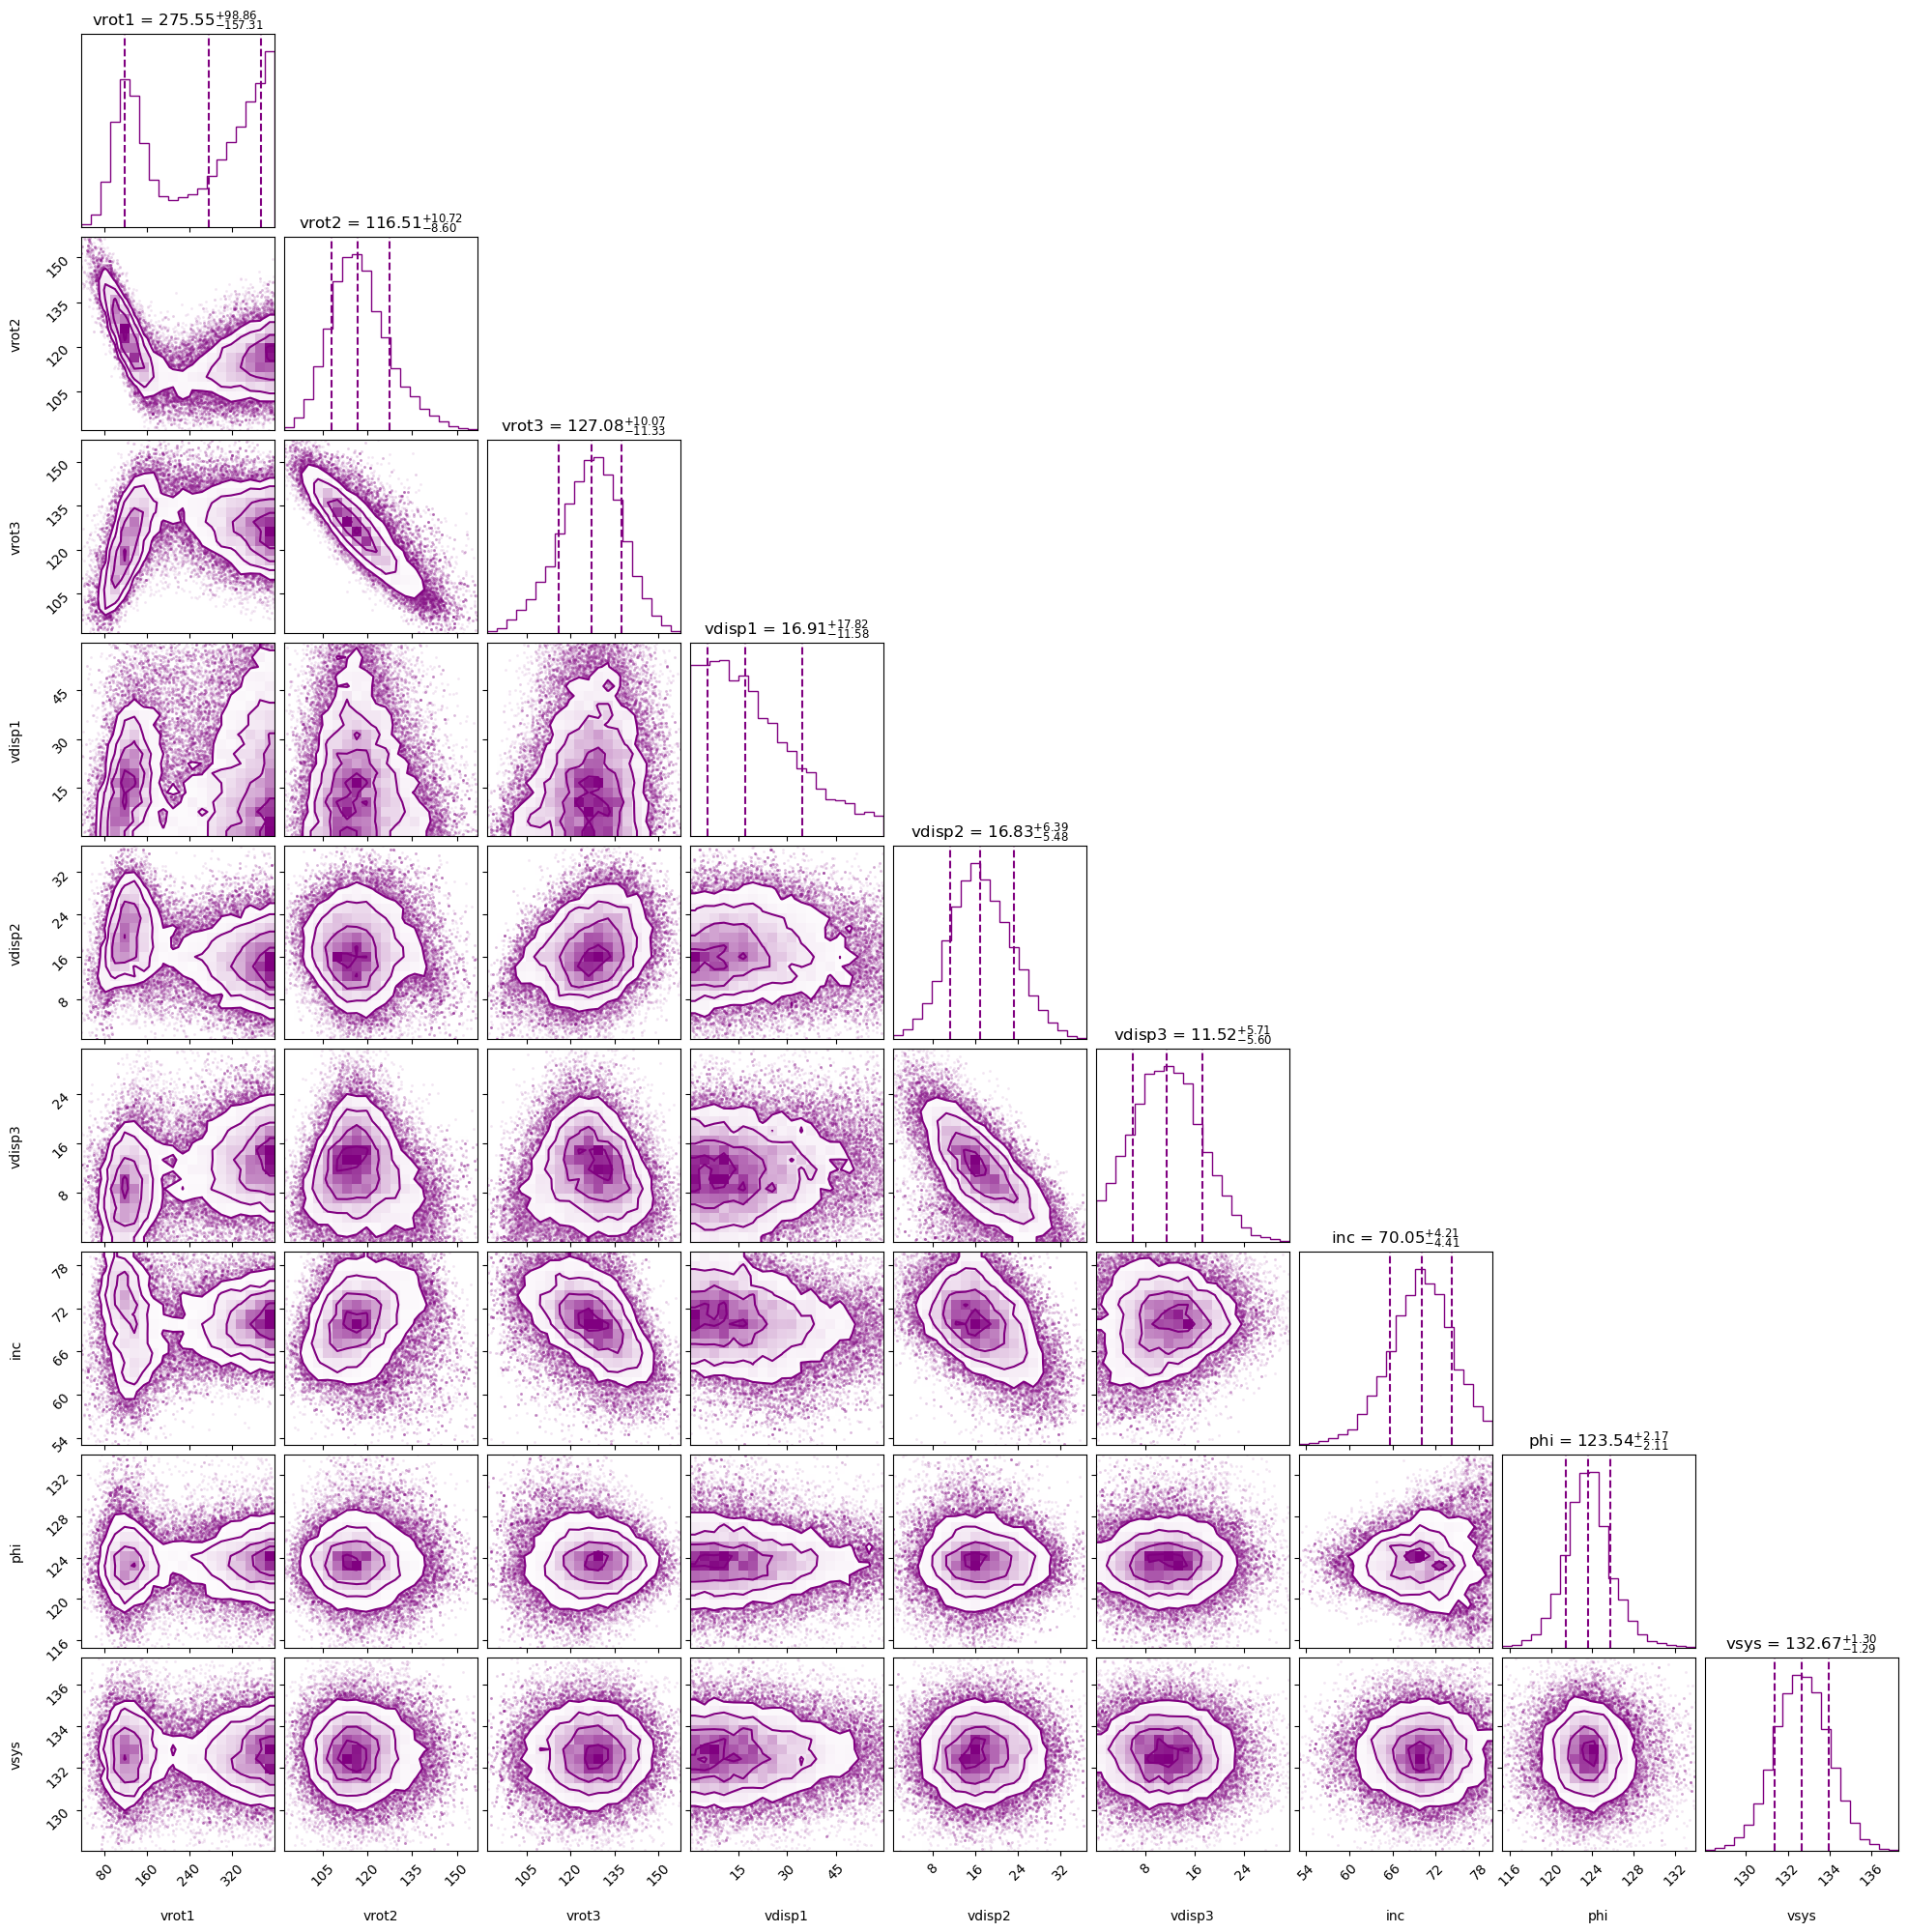

In [32]:
if method == "dynesty":
    results = f3d.results
#print(results)

# Plot a summary of the run.
    rfig, raxes = dyplot.runplot(results)
    rfig.savefig(outputfile+'output_run.pdf',bbox_inches='tight')

# Plot traces and 1-D marginalized posteriors.
    tfig, taxes = dyplot.traceplot(results)
    tfig.savefig(outputfile+'posteriors.pdf',bbox_inches='tight')

    quantiles = [0.16,0.50,0.84] # are these the contours?
    cfig, caxes = dyplot.cornerplot(results,show_titles=True,title_quantiles=quantiles,quantiles=quantiles, color='blue',max_n_ticks=5, labels=f3d.freepar_names, label_kwargs=dict(fontsize=20))
    cfig.savefig(outputfile+'corner.pdf',bbox_inches='tight')

if method == "nautilus":
    print(f3d.samples)
    quantiles = [0.16,0.50,0.84]
    cfig = corner.corner(f3d.samples, weights=f3d.weights, title_quantiles=quantiles,quantiles=quantiles,show_titles=True,
    title_kwargs={"fontsize": 12}, labels=f3d.freepar_names, color='purple',plot_datapoints=True, range=np.repeat(0.999,f3d.ndim))
    cfig.savefig(outputfile+'corner.pdf',bbox_inches='tight')


In [52]:
t = Table.read(ringfile,format='ascii') #imput params
v = Table.read(f"{outputfile}{modname}/{modname}_params.txt",format='ascii')
print(np.mean(v['PA']))

major_MOD = PVSlice( fitsname=f"{outputfile}{modname}/{modname}.fits", XPOS_PV = np.mean(v['XPOS']), YPOS_PV = np.mean(v['YPOS']),  PA_PV = np.mean(v['PA']), OUTFOLDER = outputfile+"slices")              
major_MOD.run(BBmain)
minor_MOD = PVSlice( fitsname=f"{outputfile}{modname}/{modname}.fits", XPOS_PV = np.mean(v['XPOS']), YPOS_PV = np.mean(v['YPOS']),  PA_PV = np.mean(v['PA']+90), OUTFOLDER= outputfile+"slices")              
minor_MOD.run(BBmain)

if 'RAD(arcs)' in t.colnames:
    major_MASK = PVSlice( fitsname=f"{outputfile}mask.fits", XPOS_PV=np.mean(t['YPOS(pix)']), YPOS_PV=np.mean(t['YPOS(pix)']),  PA_PV=np.mean(t['P.A.(deg)']), OUTFOLDER= outputfile+"slices")              
    major_MASK.run(BBmain)
    minor_MASK = PVSlice( fitsname=f"{outputfile}mask.fits", XPOS_PV=np.mean(t['XPOS(pix)']), YPOS_PV=np.mean(t['YPOS(pix)']),  PA_PV=np.mean(t['P.A.(deg)']+90), OUTFOLDER= outputfile+"slices")              
    minor_MASK.run(BBmain)
if 'RADII' in t.colnames:        
    major_MASK = PVSlice( fitsname=f"{outputfile}mask.fits", XPOS_PV=np.mean(t['XPOS']), YPOS_PV=np.mean(t['YPOS']),  PA_PV=np.mean(t['PA']), OUTFOLDER= outputfile+"slices")              
    major_MASK.run(BBmain)
    minor_MASK = PVSlice( fitsname=f"{outputfile}mask.fits", XPOS_PV=np.mean(t['XPOS']), YPOS_PV=np.mean(t['YPOS']),  PA_PV=np.mean(t['PA']+90), OUTFOLDER= outputfile+"slices")              
    minor_MASK.run(BBmain)

123.61

=====                                                           =====
=====                Welcome to BBarolo v1.7.7dev               =====
=====                                                           =====


-------------------------- Parameters -------------------------

FITS file to be analysed..........................[FITSFILE]  =  /Users/blanca/Documents/TESIS/software/code/TESTS/reso_tests/vdisp_lin_360_1_semifree/barbamodel/barbamodel.fits
Number of threads..................................[THREADS]  =  8
Producing output plots?..............................[PLOTS]  =  true
Showing progress bars?.............................[SHOWBAR]  =  true
Printing output messages?..........................[VERBOSE]  =  true
Directory where outputs are written..............[OUTFOLDER]  =  /Users/blanca/Documents/TESIS/software/code/TESTS/reso_tests/vdisp_lin_360_1_semifree/slices/
Redirect output messages to a file?................[LOGFILE]  =  false
Using robust statistics?......

## Errors:

In [ ]:

if method == "dynesty":
    samples = f3d.results.samples #these are all the samples that dynesty got, the last array are the parameters
    weights = np.exp(f3d.results.logwt - f3d.results.logz[-1])
    params = np.average(samples, axis=0, weights=weights) #mean of values 
if method == "nautilus":
    samples = f3d.samples
    weights = f3d.weights
    params = f3d.params

rad_mc = f3d._inri.r['radii']  # Get the radii array
labs = f3d.freepar_names

ra, pp, err_up, err_low = np.zeros(shape=(4, len(params)))
# Adjust how we index rad_mc for vrot and vdisp parameters, using modulo if needed
for i in range(len(params)):
    mcmc = np.percentile(samples[:, i], [15.865, 50, 84.135])
    q = np.diff(mcmc)
    txt = "%10s = %10.3f %+10.3f %+10.3f" % (labs[i], mcmc[1], -q[0], q[1])
    
    pp[i] = mcmc[1]
    err_low[i] = q[0]
    err_up[i] = q[1]
    
    # For vrot and vdisp parameters, assign the radius values
    if labs[i].startswith("vrot") or labs[i].startswith("vdisp"):
        # Use modulo indexing to ensure we don't go out of bounds (repeat the radii if necessary)
        idx = i % len(rad_mc)  # Ensure the index is within bounds
        ra[i] = rad_mc[idx]
    else:
        ra[i] = None  # No radius for other parameters

output_file = "errors.txt"
with open(outputfile+output_file, "w") as file:
    file.write(f"#{'Parameter':<15}{'Median':<15}{'Error_Low':<15}{'Error_Up':<15}{'Radius':<15}\n")
    
    for i in range(len(params)):

        # Check if the parameter is vrot or vdisp and write the radius
        if labs[i].startswith("vrot") or labs[i].startswith("vdisp"):

            # If the radius is None, print 'N/A' for the radius
            radius_str = f"{ra[i]:<15.6f}" if ra[i] is not None else "N/A"
            file.write(f"{labs[i]:<15}{pp[i]:<15.6f}{err_low[i]:<15.6f}{err_up[i]:<15.6f}{radius_str}\n")
        else:
            # Write the parameters without radius (vsys, inc, pa, xpos, ypos, etc.)
            file.write(f"{labs[i]:<15}{pp[i]:<15.6f}{err_low[i]:<15.6f}{err_up[i]:<15.6f}{"N/A":<15}\n")

with open(outputfile+output_file, "r") as file:
    content = file.read()
print(content)

print(f"Results saved to {output_file}")


#Parameter      Median         Error_Low      Error_Up       Radius         
vrot1          276.836853     159.498504     97.767278      180.000000     
vrot2          116.597617     8.727175       10.879884      540.000000     
vrot3          127.054016     11.494225      10.236121      900.000000     
vdisp1         16.842706      11.663895      18.243857      180.000000     
vdisp2         16.809413      5.524932       6.387621       540.000000     
vdisp3         11.552763      5.695214       5.771550       900.000000     
inc            70.034400      4.501717       4.235601       N/A            
phi            123.555286     2.113319       2.192323       N/A            
vsys           132.675743     1.305053       1.314657       N/A            

Results saved to errors.txt


## THIS CODE IS WHEN WE USE REAL DATA

In [ ]:

#Compare with "real" input parameters, this is now comparing with the output of bbarolo (normal)

#ringfile = '/Users/blanca/Documents/TESIS/software/Bbarolo-1.7/output/SGP38326/rings_final1.txt'
t = Table.read(ringfile,format='ascii')

if 'RAD(arcs)' in t.colnames:


    fig,ax = plt.subplots(nrows=4,ncols=2,figsize=(11,16))
    ax = np.ravel(ax)
    for a in ax:
        a.set_xlabel("radius (arcsec)")

    rad_mc = f3d._inri.r['radii']

    idx = f3d.freepar_idx['vrot']
    ax[0].plot(t['RAD(arcs)'],t['VROT(km/s)'],label='input')
    ax[0].errorbar(rad_mc,pp[idx],fmt='o',yerr=[err_low[idx],err_up[idx]],label='recovered')
    ax[0].set_ylabel("vrot (km/s)")
    ax[0].legend(loc='lower right')

    idx = f3d.freepar_idx['vdisp']
    ax[1].plot(t['RAD(arcs)'],t['DISP(km/s)'])
    ax[1].errorbar(rad_mc,pp[idx],fmt='o',yerr=[err_low[idx],err_up[idx]])
    ax[1].set_ylabel("vdisp (km/s)")

    if "inc" in f3d.freepar_idx:
        idx = f3d.freepar_idx['inc']
        ax[2].plot(t['RAD(arcs)'],t['INC(deg)'])
        ax[2].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
        ax[2].axhline(pp[idx][0],ls='--',color='orange')
        ax[2].set_ylabel("inc (deg)")
        ax[2].set_ylim(t['INC(deg)'][0]-20,t['INC(deg)'][0]+20)

    if "phi" in f3d.freepar_idx:
        idx = f3d.freepar_idx['phi']
        ax[3].plot(t['RAD(arcs)'],t['P.A.(deg)'])
        ax[3].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
        ax[3].axhline(pp[idx][0],ls='--',color='orange')
        ax[3].set_ylabel("phi (deg)")
        ax[3].set_ylim(t['P.A.(deg)'][0]-10,t['P.A.(deg)'][0]+10)

    if "z0" in f3d.freepar_idx:
        idx = f3d.freepar_idx['z0']
        ax[4].plot(t['RAD(arcs)'],t['Z0(arcs)'])
        ax[4].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
        ax[4].axhline(pp[idx][0],ls='--',color='orange')
        ax[4].set_ylabel("z0 (arcs)")
        ax[4].set_ylim(t['Z0(arcs)'][0]-30,t['Z0(arcs)'][0]+30)

    if "vsys" in f3d.freepar_idx:
        idx = f3d.freepar_idx['vsys']
        ax[5].plot(t['RAD(arcs)'],t['VSYS(km/s)'])
        ax[5].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
        ax[5].axhline(pp[idx][0],ls='--',color='orange')
        ax[5].set_ylabel("vsys (km/s)")
        ax[5].set_ylim(t['VSYS(km/s)'][0]-30,t['VSYS(km/s)'][0]+30)

    if "xpos" in f3d.freepar_idx:
        idx = f3d.freepar_idx['xpos']
        ax[6].plot(t['RAD(arcs)'],t['XPOS(pix)'])
        ax[6].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
        ax[6].axhline(pp[idx][0],ls='--',color='orange')
        ax[6].set_ylabel("xpos (pix)")
        ax[6].set_ylim(t['XPOS(pix)'][0]-5,t['XPOS(pix)'][0]+5)

    if "ypos" in f3d.freepar_idx:
        idx = f3d.freepar_idx['ypos']
        ax[7].plot(t['RAD(arcs)'],t['YPOS(pix)'])
        ax[7].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
        ax[7].axhline(pp[idx][0],ls='--',color='orange')
        ax[7].set_ylabel("ypos (pix)")
        ax[7].set_ylim(t['YPOS(pix)'][0]-5,t['YPOS(pix)'][0]+5)

    fig.savefig(outputfile+'parameters.pdf',bbox_inches='tight')    
else:
    print("RAD(arcsec) is not in the table.")        

RAD(arcsec) is not in the table.


## THIS CODE IS WHEN WE USE THE MODELS

['RADII', 'VROT', 'VRAD', 'VDISP', 'INC', 'PA', 'Z0', 'DENS', 'XPOS', 'YPOS', 'VSYS']


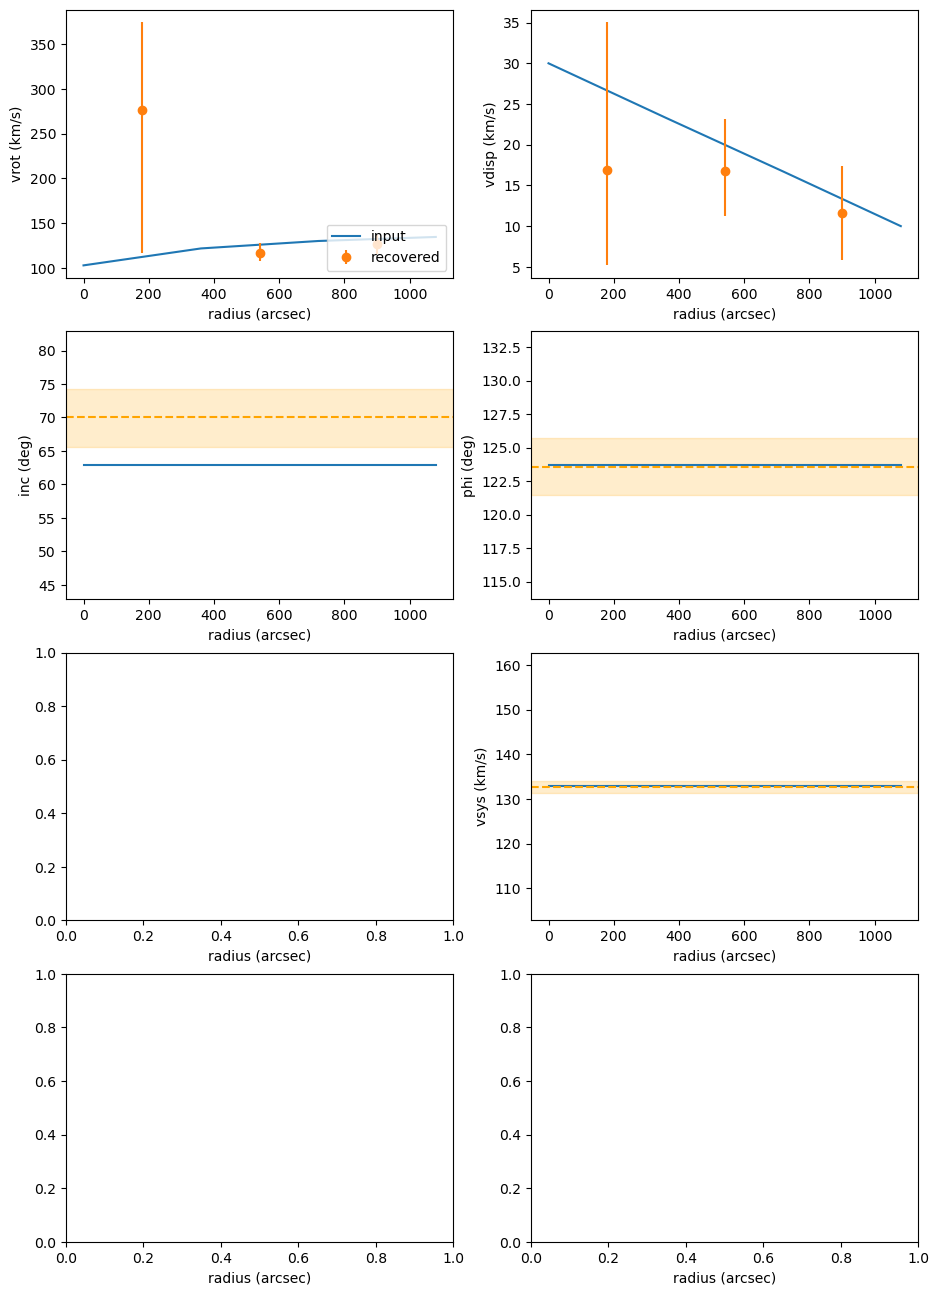

In [ ]:

t = Table.read(ringfile,format='ascii')

if 'RADII' in t.colnames:

    fig,ax = plt.subplots(nrows=4,ncols=2,figsize=(11,16))
    ax = np.ravel(ax)
    for a in ax:
        a.set_xlabel("radius (arcsec)")

    rad_mc = f3d._inri.r['radii']

    idx = f3d.freepar_idx['vrot']

    ax[0].plot(t['RADII'],t['VROT'],label='input')
    ax[0].errorbar(rad_mc,pp[idx],fmt='o',yerr=[err_low[idx],err_up[idx]],label='recovered')
    ax[0].set_ylabel("vrot (km/s)")
    ax[0].legend(loc='lower right')

    idx = f3d.freepar_idx['vdisp']
    ax[1].plot(t['RADII'],t['VDISP'])
    ax[1].errorbar(rad_mc,pp[idx],fmt='o',yerr=[err_low[idx],err_up[idx]])
    ax[1].set_ylabel("vdisp (km/s)")

    if "inc" in f3d.freepar_idx:
        idx = f3d.freepar_idx['inc']
        ax[2].plot(t['RADII'],t['INC'])
        ax[2].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
        ax[2].axhline(pp[idx][0],ls='--',color='orange')
        ax[2].set_ylabel("inc (deg)")
        ax[2].set_ylim(t['INC'][0]-20,t['INC'][0]+20)

    if "phi" in f3d.freepar_idx:
        idx = f3d.freepar_idx['phi']
        ax[3].plot(t['RADII'],t['PA'])
        ax[3].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
        ax[3].axhline(pp[idx][0],ls='--',color='orange')
        ax[3].set_ylabel("phi (deg)")
        ax[3].set_ylim(t['PA'][0]-10,t['PA'][0]+10)

    if "z0" in f3d.freepar_idx:
        idx = f3d.freepar_idx['z0']
        ax[4].plot(t['RADII'],t['Z0'])
        ax[4].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
        ax[4].axhline(pp[idx][0],ls='--',color='orange')
        ax[4].set_ylabel("z0 (arcs)")
        ax[4].set_ylim(t['Z0'][0]-30,t['Z0'][0]+30)

    if "vsys" in f3d.freepar_idx:
        idx = f3d.freepar_idx['vsys']
        ax[5].plot(t['RADII'],t['VSYS'])
        ax[5].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
        ax[5].axhline(pp[idx][0],ls='--',color='orange')
        ax[5].set_ylabel("vsys (km/s)")
        ax[5].set_ylim(t['VSYS'][0]-30,t['VSYS'][0]+30)

    if "xpos" in f3d.freepar_idx:
        idx = f3d.freepar_idx['xpos']
        ax[6].plot(t['RADII'],t['XPOS'])
        ax[6].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
        ax[6].axhline(pp[idx][0],ls='--',color='orange')
        ax[6].set_ylabel("xpos (pix)")
        ax[6].set_ylim(t['XPOS'][0]-5,t['XPOS'][0]+5)

    if "ypos" in f3d.freepar_idx:
        idx = f3d.freepar_idx['ypos']
        ax[7].plot(t['RADII'],t['YPOS'])
        ax[7].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
        ax[7].axhline(pp[idx][0],ls='--',color='orange')
        ax[7].set_ylabel("ypos (pix)")
        ax[7].set_ylim(t['YPOS'][0]-5,t['YPOS'][0]+5)
    fig.savefig(outputfile+'parameters.pdf',bbox_inches='tight')
else:
    print("RADII is not in the table.")

fig.savefig(outputfile+'parameters.pdf',bbox_inches='tight')

In [37]:
# If one wants to change the likelihood and/or prior, can just write a class that inherits
# from BayesianBBarolo and redefine the log_likelihood and prior_transform functions

class CustomBayesianBBarolo(BayesianBBarolo):
    def log_likelihood(self, theta):
        ...

    def prior_transform(self, u):
        ...

custom_f3d = CustomBayesianBBarolo(fitsname)


HEADER WARNING: TELESCOP-INSTRUME keywords not found.

Opening file /Users/blanca/Documents/TESIS/software/code/models/model_lin_vdisp_360/lin_vdisp_360.fits
Reading 75 x 75 x 62 pixels FITS file (1.3 MB)... Done. 



In [38]:
#inp = FitsCube(fitsname)
#mod = libBB.Galfit_new_par(inp._cube,inri._rings,opts._params)

# SOME THINGS TO DO 

- Fix parallel execution
- Play with dynesty samplers and parameters (these can be passed to compute() by dynesty_kwargs)
- Decide if residuals are calculated by BB or in python (more flexible)
- Need to implement output model generation + usual plots (various maps, pvs, etc...)
- Easily expandable to fit also other parameters (DENS, VVERT, DVDZ, ZCYL)
- Easily expandable to support functional forms for parameters
- There is a memory leak somewhere, memory usage grows when it should not (not a big problem though).